<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate detection of adversarial samples using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate the detection of adversarial samples using ART. Our classifier will be a **ResNet** architecture for the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) image data set.


## Contents

1.	[Loading prereqs and data](#prereqs)
2.  [Evaluating the classifier](#classifier)
3.  [Training the detector](#train_detector)
4.  [Evaluating the detector](#detector)
5.  [Crazy stuff](#crazy)

<a id="prereqs"></a>
## 1. Loading prereqs and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import load_model

from art.config import ART_DATA_PATH
from art.utils import load_dataset, get_file
from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod
from art.detection import BinaryInputDetector

import numpy as np

%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


Load the CIFAR10 data set and class descriptions:

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')

n_train = 1000
n_test = 400
n_jobs = 1
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

class_descr = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

<a id="classifier"></a>
## 2. Evaluating the classifier

Load the pre-trained classifier (a ResNet architecture):

In [3]:
path = get_file('cifar_resnet.h5',extract=False, path=ART_DATA_PATH,
                url='https://www.dropbox.com/s/ta75pl4krya5djj/cifar_resnet.h5?dl=1')
classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False, 
                             preprocessing=(0.5, 1))

In [4]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Evaluate the classifier on the first n_test test images:

In [5]:
x_test_pred = np.argmax(classifier.predict(x_test[:n_test]), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test[:n_test], axis=1))

print("Original test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_pred))

Original test data (first n_test images):
Correctly classified: 376
Incorrectly classified: 24


For illustration purposes, look at the first 9 images. (In brackets: true labels.)

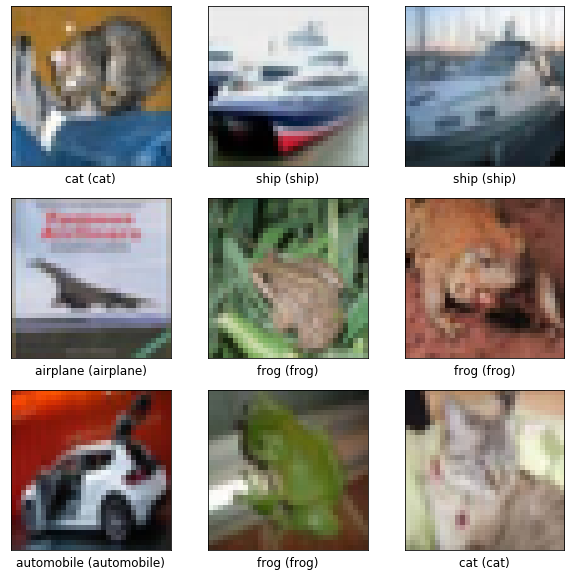

In [6]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

Generate some adversarial samples:

In [7]:
attacker = FastGradientMethod(classifier, eps=0.05)
x_test_adv = attacker.generate(x_test[:n_test]) # this takes about two minutes

Evaluate the classifier on n_test adversarial samples:

In [8]:
x_test_adv_pred = np.argmax(classifier.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test[:n_test], axis=1))

print("Adversarial test data (first n_test images):")
print("Correctly classified: {}".format(nb_correct_adv_pred))
print("Incorrectly classified: {}".format(n_test-nb_correct_adv_pred))

Adversarial test data (first n_test images):
Correctly classified: 86
Incorrectly classified: 314


Now plot the adversarial images and their predicted labels (in brackets: true labels).

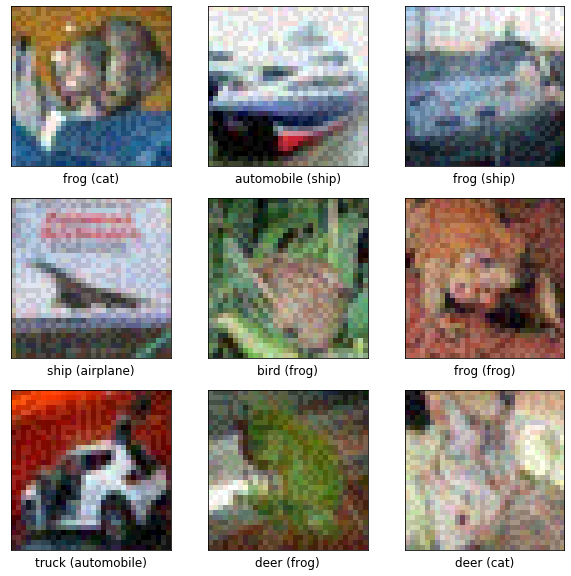

In [9]:
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_test_adv_pred[i]], class_descr[np.argmax(y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(x_test_adv[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

<a id="detector"></a>
## 3. Generate some adversarial images

In [10]:
eps_range = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
all_x_test_adv = {}

for eps in eps_range:
    print("Generating %d attacks for eps=%.2f" % (n_test, eps))
    if eps > 0:
        attacker.set_params(**{'eps': eps})
        all_x_test_adv[eps] = attacker.generate(x_test)
    else:
        all_x_test_adv[eps] = x_test

Generating 400 attacks for eps=0.00
Generating 400 attacks for eps=0.01
Generating 400 attacks for eps=0.02
Generating 400 attacks for eps=0.03
Generating 400 attacks for eps=0.04
Generating 400 attacks for eps=0.05
Generating 400 attacks for eps=0.10
Generating 400 attacks for eps=0.15
Generating 400 attacks for eps=0.20
Generating 400 attacks for eps=0.25
Generating 400 attacks for eps=0.30
Generating 400 attacks for eps=0.35
Generating 400 attacks for eps=0.40
Generating 400 attacks for eps=0.45
Generating 400 attacks for eps=0.50


In [11]:
# generate some data for supervised detectors
attacker.set_params(**{'eps': 0.05})
x_train_adv = attacker.generate(x_train)

<a id="crazy"></a>
## 5. Crazy stuff


In [24]:
from elvis_lib import LIDDetector, LIDDetectorBickel, RawActivationsDetector

In [110]:
detectors = {}
layer_names = ["input_1"] + ["conv2d_%d" % l for l in range(8, 9)]
n_components = 20
x_train_sup_detector = np.concatenate((x_train, x_train_adv), axis=0)
y_train_sup_detector = np.concatenate((-np.ones((len(x_train))), np.ones(len(x_train_adv))))
detectors["unsupervised_raw"] = RawActivationsDetector(classifier_model, layer_names=layer_names,
                                                       n_components=n_components, n_jobs=n_jobs).fit(x_train)
detectors["supervised_raw"] = RawActivationsDetector(classifier_model,
                                                     layer_names=layer_names,
                                                     n_components=n_components,
                                                     n_jobs=n_jobs).fit(x_train_sup_detector,
                                                                        y_train_sup_detector)
detectors["unsupervised_lid"] = LIDDetector(classifier_model,
                                            layer_names=layer_names,
                                            n_neighbors=200, n_jobs=n_jobs).fit(x_train)
detectors["unsupervised_lid2"] = LIDDetectorBickel(classifier_model, layer_names=layer_names,
                                                   k1=180, k2=200).fit(x_train)

Building activation model...
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) to layer 'input_1'...
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) to layer 'conv2d_8'...
Fitting OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)..
Building activation model...
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) to layer 'input_1'...
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) to layer 'conv2d_8'...


KeyboardInterrupt: 

In [140]:
# evaluate the detectors
from sklearn.metrics import roc_auc_score, accuracy_score

def roc_auc_score_FIXED(y_true, y_pred):
    if len(np.unique(y_true)) == 1: # bug in roc_auc_score
        return accuracy_score(y_true, np.rint(y_pred))
    return roc_auc_score(y_true, y_pred)

# scores = {}
for which, detector in detectors.items():
    if "unsupervised_dbscan" not in which:
        continue
    print("Computing scores for %s detector" % which)
    y_true = np.concatenate((-np.ones(n_test), np.ones(n_test)))
    if "unsupervised" in which:
        y_true = -y_true
    scores[which] = []
    for eps in eps_range[::-1]:
        if True:
            if eps > 0:
                y_pred = detector.predict(np.vstack((x_test, all_x_test_adv[eps])))
                score = roc_auc_score_FIXED(y_pred, y_true)
            else:
                score = 0.5
        else:
            score = (detector.predict(all_x_test_adv[eps]) == -1).sum()
        print("%.2f ==> %.2f" % (eps, score))  
        if which not in scores:
            scores[which] = []
        scores[which].append(score)
    scores[which].sort()

Computing scores for unsupervised_dbscan detector
0.50 ==> 1.00
0.45 ==> 1.00
0.40 ==> 1.00
0.35 ==> 1.00
0.30 ==> 0.98
0.25 ==> 0.92
0.20 ==> 0.78
0.15 ==> 0.75
0.10 ==> 0.75
0.05 ==> 0.50
0.04 ==> 0.50
0.03 ==> 0.50
0.02 ==> 0.50
0.01 ==> 0.50
0.00 ==> 0.50
Computing scores for unsupervised_dbscan_eps=30.00 detector
0.50 ==> 0.82
0.45 ==> 0.82
0.40 ==> 0.82
0.35 ==> 0.82
0.30 ==> 0.82
0.25 ==> 0.82
0.20 ==> 0.82
0.15 ==> 0.82
0.10 ==> 0.82
0.05 ==> 0.68
0.04 ==> 0.62
0.03 ==> 0.58
0.02 ==> 0.54
0.01 ==> 0.51
0.00 ==> 0.50
Computing scores for unsupervised_dbscan_eps=40.00 detector
0.50 ==> 0.99
0.45 ==> 0.99
0.40 ==> 0.99
0.35 ==> 0.99
0.30 ==> 0.99
0.25 ==> 0.99
0.20 ==> 0.96
0.15 ==> 0.81
0.10 ==> 0.70
0.05 ==> 0.56
0.04 ==> 0.51
0.03 ==> 0.50
0.02 ==> 0.47
0.01 ==> 0.47
0.00 ==> 0.50
Computing scores for unsupervised_dbscan_eps=50.00 detector
0.50 ==> 1.00
0.45 ==> 1.00
0.40 ==> 1.00
0.35 ==> 1.00
0.30 ==> 0.98
0.25 ==> 0.91
0.20 ==> 0.78
0.15 ==> 0.71
0.10 ==> 0.50
0.05 ==> 0.50


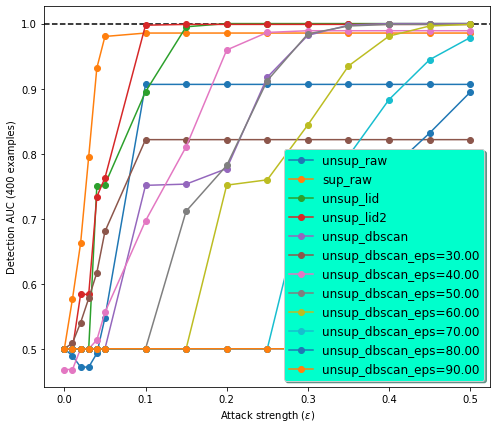

In [143]:
# plot the results
fig, ax = plt.subplots(figsize=(8, 7))
if True:
    ax.axhline(1., linestyle="--", c="k")
else:
    ax.axhline(n_test, linestyle="--", c="k")
for which in scores:
    ax.plot(eps_range, scores[which], '-o', label=which.replace("supervised", "sup"))

legend = ax.legend(loc='best', shadow=True, fontsize="large")
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength ($\\varepsilon$)')
plt.ylabel('Detection AUC (%d examples)' % n_test)
plt.show()

In [132]:
from sklearn.cluster import DBSCAN


class PredictiveDBSCAN(DBSCAN):
    def predict(self, X):
        n_test = len(X)
        y_pred = -np.ones(shape=n_test, dtype=int)
        for i in range(n_test):
            diff = self.components_ - X[i]  # NumPy broadcasting
            dist = np.linalg.norm(diff, axis=1)  # Euclidean distance
            shortest_dist_idx = np.argmin(dist)
            if dist[shortest_dist_idx] < self.eps:
                y_pred[i] = self.labels_[self.core_sample_indices_[shortest_dist_idx]]
                
        y_pred[y_pred == 0] = 1
        return y_pred
    

class DBSCANDetector(RawActivationsDetector):
    def __init__(self, classifier_model, layer_names=None, n_components=20,
                 dbscan_params=dict(eps=50, algorithm="ball_tree"),
                 n_jobs=1):
        super(DBSCANDetector, self).__init__(classifier_model,
                                             layer_names=layer_names,
                                             n_components=n_components,
                                             n_jobs=n_jobs)
        self.dbscan_params = dbscan_params
        
    def fit(self, X):
        RawActivationsDetector.fit(self, X)
        activations = self.transform(X)
        dbscan = PredictiveDBSCAN(n_jobs=self.n_jobs, **self.dbscan_params)
        print("Fitting %s..." % dbscan)
        self.dbscan_ = dbscan.fit(activations)
        return self
    
    def predict(self, X):
        activations = self.transform(X)
        return self.dbscan_.predict(activations)


In [137]:
for dbscan_eps in range(30, 100, 10):
    name = "unsupervised_dbscan_eps=%.2f" % dbscan_eps
    detector = DBSCANDetector(classifier_model, layer_names=layer_names,
                              n_components=n_components,
                              dbscan_params=dict(eps=dbscan_eps))
    print(detector)
    detector.fit(x_train)
    detectors[name] = detector

DBSCANDetector(classifier_model=<keras.engine.training.Model object at 0x7f8b91e6e350>,
               dbscan_params={'eps': 30}, layer_names=['input_1', 'conv2d_8'],
               n_components=20, n_jobs=1)
Building activation model...
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) to layer 'input_1'...
Fitting PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False) to layer 'conv2d_8'...
Fitting OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
            max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)..
Fitting PredictiveDBSCAN(algorithm='auto', eps=30, leaf_size=30, metric='euclidean',
                 metric_params=None, min_samples=5, n_jobs=1, p=None)...
DBSCANDetector(classifier_model=<keras.engine.training.Model object at 0x7f8b91e6e350>,
               dbscan_params={'eps': 40}, layer_name

In [93]:
detectors["unsupervised_dbscan"].predict(all_x_test_adv[0.5])

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

In [62]:
DBSCAN?

Two-NN estimator of intrinsic dimension
===

In [16]:
from elvis_lib import LIDDetector2NN

ImportError: cannot import name 'LIDDetector2NN' from 'elvis_lib' (/home/elvis/CODE/FORKED/adversarial-robustness-toolbox/notebooks/elvis_lib/__init__.py)

In [ ]:
from colour import Color
blue = Color("blue")
colors = list(blue.range_to(Color("red"), 1 + len(all_x_test_adv)))
colors = [np.array(color.get_rgb())[None, :] for color in colors]
layer_indices = [0, 25]
_, axes = plt.subplots(len(layer_indices), 2, figsize=(2 * 5, len(layer_indices) * 5))
legended = False
for layer_idx, (ax1, ax2) in zip(layer_indices, axes):
    ids = []
    toto = LIDDetector2NN(layer_idx=layer_idx)
    for eps, c in zip(all_x_test_adv, colors):
        toto.fit(all_x_test_adv[eps])
        ax1.scatter(toto.xx_, toto.yy_, label="$\\varepsilon=%.2f$" % eps, c=c)
        ids.append(toto.intrinsic_dim_)

    ax1.set_xlabel("$\\log(\\mu)$")
    ax1.set_ylabel("$-\\log(1-F(\\mu))$")
        
    if not legended:
        legended = True
        ax1.legend(loc="best", ncol=1)
            
    ax2.plot(eps_range, ids, linewidth=3)
    ax2.set_xlabel("Attack strength ($\\varepsilon$)")
    ax2.set_ylabel("Intrinsic dimension ($d$)")
plt.tight_layout()
plt.savefig("intrinsic.png", dpi=200, bbox_inches="tight")

In [ ]:
layer_idx = 25
colors = list(blue.range_to(Color("red"), 1 + len(all_x_test_adv)))
colors = [np.array(color.get_rgb())[None, :] for color in colors]
activation_model = keras.models.Model(input=classifier_model.input,
                                      output=classifier_model.layers[layer_idx].output)
lid = LocalIntrinsicDimensionMLE(preprocessor=lambda X: activation_model.predict(X).reshape((len(X), -1)))
lid.fit(x_train)
print(lid.intrinsic_dims_.mean())
ids = []
import seaborn as sns
plt.figure(figsize=(5, 5))
for eps, color in zip(eps_range, colors):
    d = lid.predict(all_x_test_adv[eps])
    sns.kdeplot(d, c=color[0], label="$\\varepsilon=%.2f$" % eps)
    ids.append(d)
plt.legend(loc="best")
plt.xlabel("Local Intrinsic Dimension")
plt.tight_layout()
# plt.plot(eps_range, ids)

In [ ]:
plt.errorbar(eps_range, np.mean(ids, axis=1), yerr=np.std(ids, axis=1))
plt.xlabel("Attack strength ($\\varepsilon$)")
plt.ylabel("Local Intrinsic Dimension")

In [ ]:
import seaborn as sns
sns.kdeplot(lid.intrinsic_dims_)
sns.kdeplot(lid._compute_lids(lid._get_activations(all_x_test_adv[.05])))
plt.axvline(lid.cutoff_, linestyle="--", c="k")

In [ ]:
from scipy.stats import cumfreq
cumfreq(toto.lid2nn_.mus_, 32)[0]

In [ ]:
plt.plot(1 - toto.lid2nn_.mus_ ** (-toto.intrinsic_dim_))

In [ ]:
plt.hist(toto.lid2nn_.mus_, bins=15);
confidence = .95
tail = (1. / (1. - confidence)) ** (1. / toto.intrinsic_dim_)
plt.axvline(tail, linestyle="--", c="k")

In [ ]:
x = np.random.randn(10000, 3)
from sklearn.model_selection import KFold
folds = KFold(n_splits=100)
dims = []
for indices, _ in folds.split(x):
    lid2nn = LocalIntrinsicDimensionMLE2NN()
    dims.append(lid2nn.fit(x[indices]).intrinsic_dim_)
dims = np.asanyarray(dims)

In [ ]:
plt.hist(1. / np.log(lid2nn._compute_mus(x)), 32);

In [ ]:
import keras.backend as K
grads = K.gradients(classifier_model.layers[25].output, classifier_model.input)[0]
compute_grads = K.function(classifier_model.input, grads)
compute_grads(x_test).shape


In [ ]:
toto = LIDDetector2NN(layer_idx=25).fit(x_train[:200])
confidence = .95
tail = (1. / (1. - confidence)) ** (-toto.intrinsic_dim_)

In [ ]:
import seaborn as sns
sns.kdeplot(toto.lid2nn_.mus_)
confidence = .95
tail = confidence ** (-1 / toto.intrinsic_dim_)
plt.axvline(tail, linestyle="--", c="k")
for eps, color in zip(eps_range, colors):
    sns.kdeplot(toto.lid2nn_._compute_mus(toto._get_activations(all_x_test_adv[eps])), c=color[0])

In [ ]:
sns.kdeplot(toto.lid2nn_.mus_)
confidence = .95
tail = confidence ** (-1 / toto.intrinsic_dim_)
plt.axvline(tail, linestyle="--", c="k")

In [ ]:
import scipy.stats


In [ ]:
from elvis_lib.utils import plot_multivariate_normal

In [ ]:
lid = detectors["unsupervised_lid"]
mean = lid.confidence_ellipsoid_.location_
cov = lid.confidence_ellipsoid_.covariance_
plot_multivariate_normal(mean, cov, x_width=50, y_width=50);
if False:
    plt.scatter(lid.intrinsic_dims_["conv2d_7"], lid.intrinsic_dims_["conv2d_8"],
                s=2)

plt.scatter(aux["conv2d_7"], aux["conv2d_8"], c="r", s=5)

plt.xlabel("conv2d_7 lids")
plt.ylabel("conv2d_8 lids")

In [ ]:
aux = lid._compute_lids(lid.get_activations(x_train))

In [ ]:
lid.confidence_ellipsoid_.predict(np.transpose([aux["input_1"], aux["conv2d_8"]]))

In [ ]:
[(layer.name, layer.output.shape) for layer in classifier_model.layers if "conv2d" in layer.name]

In [ ]:
del detectors

In [ ]:
NearestNeighbors?

In [ ]:
activations = dict(zip(detectors["unsupervised_lid"].layer_names_,
                       [detectors["unsupervised_lid"].activation_model_.predict(x_test)]))

In [ ]:
plt.matshow(activations["conv2d_8"][5, :, :, 1])

In [ ]:
from sklearn.decomposition import DictionaryLearning
pca = PCA(n_components=10).fit_transform(activations["conv2d_8"].reshape(len(x_test), -1))

In [ ]:
plt.plot(pca.T);

In [ ]:
RawActivationsDetector?

In [115]:
DBSCAN?

In [145]:
np.log(1.5)

0.4054651081081644